In [1]:
# パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

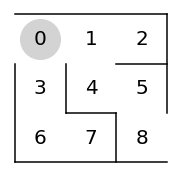

In [13]:
# 迷路の作成
fig = plt.figure(figsize=(3,3))

# 壁
plt.plot([0,3], [3,3], color='k') # 第一引数はx軸、第二引数はy軸における、線分の端点の座標
plt.plot([0,3], [0,0], color='k')
plt.plot([0,0], [0,2], color='k')
plt.plot([3,3], [1,3], color='k')
plt.plot([1,1], [1,2], color='k')
plt.plot([2,3], [2,2], color='k')
plt.plot([2,1], [1,1], color='k')
plt.plot([2,2], [1,0], color='k')


# 数字
for i in range(3):
  for j in range(3):
    plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 目盛りと枠の非表示
plt.tick_params(
    bottom=False, top=False ,
    labelbottom=False, right=False, left=False, labelleft=False
)

plt.box(False)

In [3]:
# パラメータθの初期値の準備
theta_0 = np.array([
  [np.nan, 1, 1, np.nan], # 0 上、右、下、左
  [np.nan, 1, 1, 1], # 1
  [np.nan, np.nan, np.nan, 1], # 2
  [1, np.nan, 1, np.nan], # 3
  [1, 1, np.nan, np.nan], # 4
  [np.nan, np.nan, 1, 1], # 5
  [1, 1, np.nan, np.nan], # 6
  [np.nan, np.nan, np.nan, 1], # 7
])

In [4]:
print(theta_0.shape)

(8, 4)


In [5]:
# パラメータθを方策に変換
def get_pi(theta):
  # ソフトマックス関数で変換
  [m, n] = theta.shape
  pi = np.zeros((m, n))
  exp_theta = np.exp(theta)
  for i in range(0, m):
    pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
  pi = np.nan_to_num(pi)
  return pi

In [6]:
# パラメータθの初期値を方策に変換
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [7]:
# 方策に従って行動を取得
def get_a(pi, s):
  # 方策の確率に従って行動を返す
  return np.random.choice([0, 1, 2, 3], p=pi[s])

In [8]:
# 行動に従って状態を取得
def get_s_next(s, a):
  if a == 0: # 上
    return s - 3
  if a == 1: # 右
    return s + 1 
  if a == 2: # 下
    return s + 3
  if a == 3: # 左
    return s - 1

In [9]:
# １エピソードの実行
def play(pi):
  s = 0 # 状態
  s_a_history = [[0, np.nan]] # 状態と行動の履歴

  # エピソード完了までループ
  while True:
    # 方策に従って行動と次の状態の取得
    a = get_a(pi, s)
    s_next = get_s_next(s, a)

    # 履歴の更新
    s_a_history[-1][1] = a
    s_a_history.append([s_next, np.nan])

    # 終了判定
    if s_next == 8:
      break
    else:
      s = s_next

  return s_a_history

In [10]:
def update_theta(theta, pi, s_a_history):
  eta = 0.1 # 学習係数
  total = len(s_a_history) - 1 # ゴールまでにかかった総ステップ数
  [s_count, a_count] = theta.shape

  # パラメータθの変化量の計算
  delta_theta = theta.copy()
  for i in range(0, s_count):
    for j in range(0, a_count):
      if not(np.isnan(theta[i][j])):
        # ある状態である行動を採る回数
        sa_ij = [sa for sa in s_a_history if sa == [i, j]]
        n_ij = len(sa_ij)

        # ある状態で何らかの行動を採る回数
        sa_i = [sa for sa in s_a_history if sa[0] == i]
        n_i = len(sa_i)

        # パラメータθの変化量
        delta_theta[i, j] = (n_ij + pi[i, j] * n_i) / total

  # パラメータθの更新
  return theta + delta_theta

In [15]:
stop_epsilon = 10**-3 # 閾値
theta = theta_0 # パラメータθ
pi = pi_0 # 方策

# エピソードを繰り返して学習
for episode in range(1000):
  # １エピソード実行して履歴取得
  s_a_history = play(pi)

  # パラメータθの更新
  theta = update_theta(theta, pi, s_a_history)

  # 方策の更新
  pi_new = get_pi(theta)

  # 方策の変化量
  pi_delta = np.sum(np.abs(pi_new - pi))
  pi = pi_new

  # 出力
  print('エピソード: {}, ステップ: {}, 方向変化量: {:.4f}'.format(
      episode, len(s_a_history)-1, pi_delta  
  ))

  # 終了判定
  if pi_delta < stop_epsilon: # 方策の変化量が閾値以下
    break

エピソード: 0, ステップ: 22, 方向変化量: 0.1362
エピソード: 1, ステップ: 44, 方向変化量: 0.0685
エピソード: 2, ステップ: 36, 方向変化量: 0.1445
エピソード: 3, ステップ: 38, 方向変化量: 0.1298
エピソード: 4, ステップ: 52, 方向変化量: 0.0957
エピソード: 5, ステップ: 54, 方向変化量: 0.1556
エピソード: 6, ステップ: 116, 方向変化量: 0.0904
エピソード: 7, ステップ: 38, 方向変化量: 0.1468
エピソード: 8, ステップ: 6, 方向変化量: 0.3288
エピソード: 9, ステップ: 48, 方向変化量: 0.1342
エピソード: 10, ステップ: 4, 方向変化量: 0.5097
エピソード: 11, ステップ: 10, 方向変化量: 0.2961
エピソード: 12, ステップ: 30, 方向変化量: 0.1388
エピソード: 13, ステップ: 34, 方向変化量: 0.1870
エピソード: 14, ステップ: 10, 方向変化量: 0.2647
エピソード: 15, ステップ: 10, 方向変化量: 0.2663
エピソード: 16, ステップ: 4, 方向変化量: 0.4989
エピソード: 17, ステップ: 4, 方向変化量: 0.4771
エピソード: 18, ステップ: 16, 方向変化量: 0.0810
エピソード: 19, ステップ: 8, 方向変化量: 0.2155
エピソード: 20, ステップ: 4, 方向変化量: 0.3884
エピソード: 21, ステップ: 10, 方向変化量: 0.1034
エピソード: 22, ステップ: 6, 方向変化量: 0.1777
エピソード: 23, ステップ: 4, 方向変化量: 0.2721
エピソード: 24, ステップ: 4, 方向変化量: 0.2142
エピソード: 25, ステップ: 4, 方向変化量: 0.1599
エピソード: 26, ステップ: 4, 方向変化量: 0.1135
エピソード: 27, ステップ: 4, 方向変化量: 0.0769
エピソード: 28, ステップ: 4, 方向変化量: 0.0503
エピソード: 

In [32]:
# アニメーションの定期処理を行う関数
def animate(i):
  state = s_a_history[i][0]
  circle.set_data((state % 3) + 0.5, 2.5 - (state // 3))
  return circle

# アニメーションの表示
anim = animation.FuncAnimation(fig, animate,  \
          frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())